# Generative Model Benchmarking

The goal here is to use the [data programing paradigm](https://arxiv.org/abs/1605.07723) to probabilistically label our training dataset for the disease associates gene realtionship. The label functions have already been generated and now it is time to train the generative model. This model captures important features such as agreements and disagreements between label functions; furthermore, this model can capture the dependency structure between label functions (i.e. correlations between label functions). More information can be found in this [blog post](https://hazyresearch.github.io/snorkel/blog/structure_learning.html) or in this [paper](https://arxiv.org/abs/1703.00854). The underlying hypothesis here is: **Modeling dependency structure between label functions has better performance compared to the conditionally independent model.**

## Set up The Environment

The few blocks below sets up our python environment to perform the experiment.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from itertools import product
import os
import sys

sys.path.append(os.path.abspath('../../../modules'))

import pandas as pd
from tqdm import tqdm_notebook

In [2]:
#Set up the environment
username = "danich1"
password = "snorkel"
dbname = "pubmeddb"

#Path subject to change for different os
database_str = "postgresql+psycopg2://{}:{}@/{}?host=/var/run/postgresql".format(username, password, dbname)
os.environ['SNORKELDB'] = database_str

from snorkel import SnorkelSession
session = SnorkelSession()

In [3]:
from snorkel.annotations import LabelAnnotator
from snorkel.learning.structure import DependencySelector
from snorkel.models import candidate_subclass

from utils.label_functions import DG_LFS

from utils.notebook_utils.dataframe_helper import load_candidate_dataframes
from utils.notebook_utils.label_matrix_helper import (
    get_auc_significant_stats, 
    get_overlap_matrix, 
    get_conflict_matrix, 
    make_cids_query,
    label_candidates
)
from utils.notebook_utils.train_model_helper import train_generative_model
from utils.notebook_utils.plot_helper import (
    plot_label_matrix_heatmap, 
    plot_roc_curve, 
    plot_generative_model_weights, 
    plot_pr_curve
)

In [4]:
DiseaseGene = candidate_subclass('DiseaseGene', ['Disease', 'Gene'])

In [5]:
quick_load = True

## Load the data for Generative Model Experiments

In [6]:
spreadsheet_names = {
    'train': '../../sentence_labels_train.xlsx',
    'dev': '../../sentence_labels_train_dev.xlsx',
    'test': '../../sentence_labels_dev.xlsx'
}

In [7]:
candidate_dfs = {
    key:load_candidate_dataframes(spreadsheet_names[key])
    for key in spreadsheet_names
}

for key in candidate_dfs:
    print("Size of {} set: {}".format(key, candidate_dfs[key].shape[0]))

Size of train set: 50000
Size of dev set: 60
Size of test set: 210


In [8]:
label_functions = (
    list(DG_LFS["DaG_DB"].values()) + 
    list(DG_LFS["DaG_TEXT"].values())
) 

if quick_load:
    labeler = LabelAnnotator(lfs=[])

    label_matricies = {
        key:labeler.load_matrix(session, cids_query=make_cids_query(session, candidate_dfs[key]))
        for key in candidate_dfs
    }

else:
    labeler = LabelAnnotator(lfs=label_functions)

    label_matricies = {
        key:label_candidates(
            labeler, 
            cids_query=make_cids_query(session, candidate_dfs[key]),
            label_functions=label_functions,
            apply_existing=(key!='train')
        )
        for key in candidate_dfs
    }

In [9]:
lf_names = [
    label_matricies['test'].get_key(session, index).name 
    for index in range(label_matricies['test'].shape[1])
]

## Visualize Label Functions

Before training the generative model, here are some visualizations for the given label functions. These visualizations are helpful in determining the efficacy of each label functions as well as observing the overlaps and conflicts between each function.

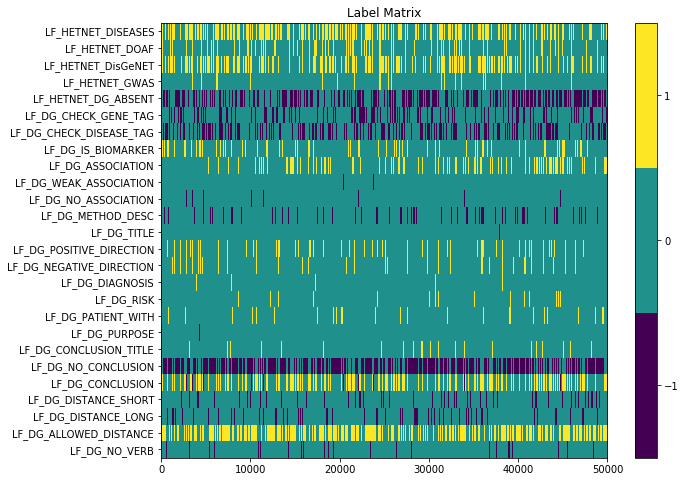

In [14]:
plot_label_matrix_heatmap(label_matricies['train'].T, 
                          yaxis_tick_labels=lf_names, 
                          figsize=(10,8))

Looking at the heatmap above, this is a decent distribution of labels. Some of the label functions are outputting a lot of labels (distant supervision ones) and some are very sparse in their output. Nevertheless, nothing shocking scream out here in terms of label function performance. 

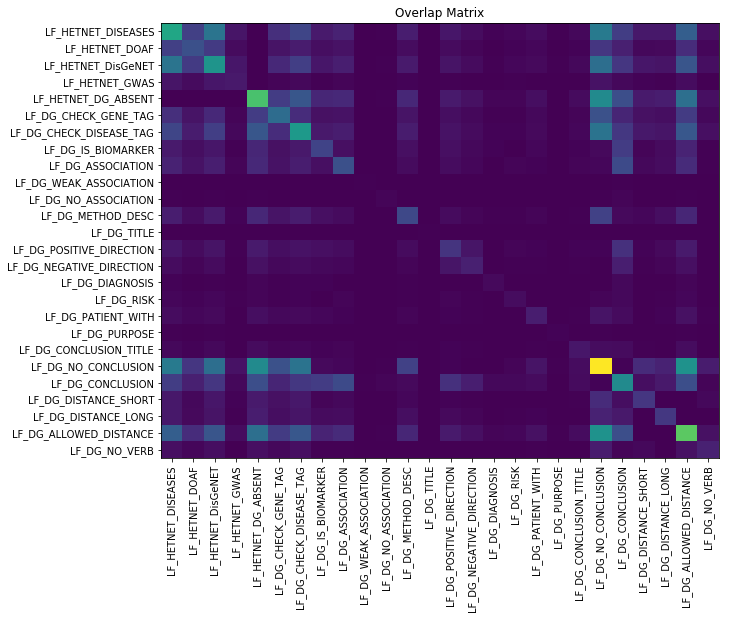

In [15]:
plot_label_matrix_heatmap(get_overlap_matrix(label_matricies['train'], normalize=True), 
                          yaxis_tick_labels=lf_names, xaxis_tick_labels=lf_names,
                          figsize=(10,8), colorbar=False, plot_title="Overlap Matrix")

The overlap matrix above shows how two label functions overlap with each other. The brighter the color the more overlaps a label function has with another label function. Ignoring the diagonals, there isn't much overlap between functions as expected.

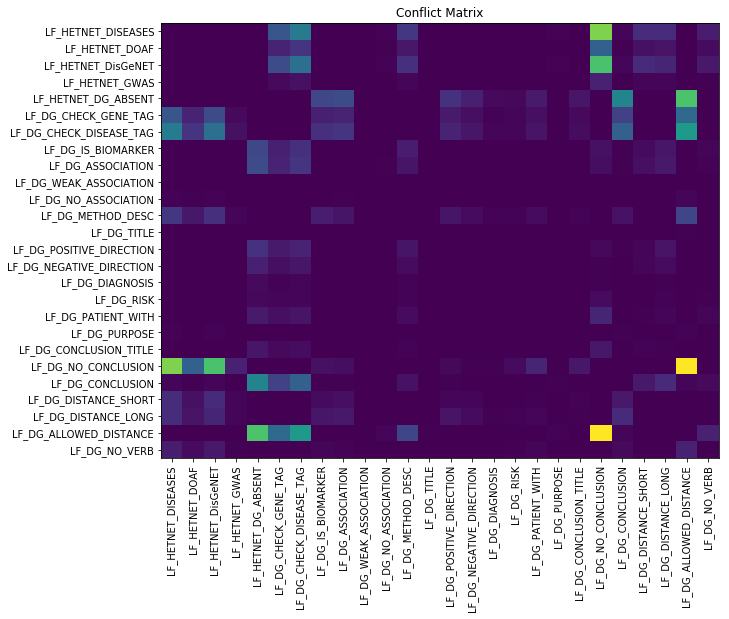

In [16]:
plot_label_matrix_heatmap(get_conflict_matrix(label_matricies['train'], normalize=True), 
                          yaxis_tick_labels=lf_names, xaxis_tick_labels=lf_names,
                          figsize=(10,8), colorbar=False, plot_title="Conflict Matrix")

The conflict matrix above shows how often label functions conflict with each other. The brighter the color the more conflict a label function has with another function. Ignoring the diagonals, there isn't many conflicts between functions except for the LF_DG_NO_CONCLUSION and LF_DG_ALLOWED_DISTANCE. Possible reasons for lack of conflicts could be lack of coverage a few functions have, which is shown in the cell below.

In [17]:
label_matricies['train'].lf_stats(session)

,j,Coverage,Overlaps,Conflicts
LF_HETNET_DISEASES,0,0.40212,0.40212,0.35668
LF_HETNET_DOAF,1,0.16650,0.16650,0.14284
LF_HETNET_DisGeNET,2,0.35356,0.35356,0.31336
LF_HETNET_GWAS,3,0.04684,0.04684,0.04056
LF_HETNET_DG_ABSENT,4,0.48574,0.48574,0.34682
LF_DG_CHECK_GENE_TAG,5,0.23946,0.23946,0.20266
LF_DG_CHECK_DISEASE_TAG,6,0.36632,0.36632,0.31128
LF_DG_IS_BIOMARKER,7,0.13680,0.13680,0.11784
LF_DG_ASSOCIATION,8,0.16612,0.16612,0.13418
LF_DG_WEAK_ASSOCIATION,9,0.00322,0.00322,0.00260


# Train the Generative Model

After visualizing the label functions and their associated properties, now it is time to work on the generative model. AS with common machine learning pipelines, the first step is to find the best hyperparameters for this model. Using the grid search algorithm, the follow parameters were optimized: amount of burnin, strength of regularization, number of epochs to run the model.

## Set the hyperparameter grid search

In [10]:
regularization_grid = pd.np.round(pd.np.linspace(0.001, 0.8, num=25), 3)

## What are the best hyperparameters for the conditionally independent model?

In [ ]:
gen_ci_models = {
   "{}".format(str(parameter)):train_generative_model(
        label_matricies['train'],
        burn_in=100,
        epochs=100,
        reg_param=parameter,
        step_size=1/label_matricies['train'].shape[0]
    )
    for parameter in tqdm_notebook(regularization_grid)
}

HBox(children=(IntProgress(value=0, max=25), HTML(value='')))

Inferred cardinality: 2


In [18]:
ci_marginal_df = pd.DataFrame(pd.np.array([
    gen_ci_models[model_name].marginals(label_matricies['dev'])
    for model_name in sorted(gen_ci_models.keys())
]).T, columns=sorted(gen_ci_models.keys()))
ci_marginal_df['candidate_id'] = candidate_dfs['dev'].candidate_id.values
ci_marginal_df.head(2)

,0.001,0.034,0.068,0.101,0.134,0.167,0.201,0.234,0.267,0.301,...,0.534,0.567,0.6,0.634,0.667,0.7,0.733,0.767,0.8,candidate_id
0,0.012824,0.021031,0.985491,0.047937,0.984018,0.982898,0.981325,0.978753,0.973549,0.957889,...,0.889715,0.895324,0.900546,0.904458,0.908593,0.912058,0.915502,0.918541,0.921197,22586
1,0.010568,0.023781,0.993994,0.095998,0.995980,0.996601,0.997042,0.997386,0.997501,0.997159,...,0.996701,0.997088,0.997428,0.997718,0.997955,0.998167,0.998341,0.998481,0.998606,22686


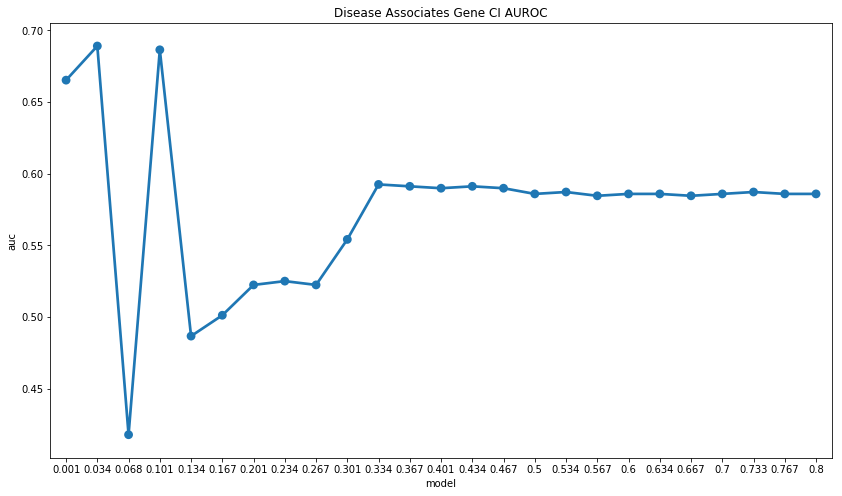

In [22]:
ci_aucs = plot_roc_curve(
    ci_marginal_df.drop("candidate_id", axis=1), 
    candidate_dfs['dev'].curated_dsh,
    model_type='scatterplot', xlim=[0,0.7], figsize=(14,8), 
    plot_title="Disease Associates Gene CI AUROC"
)

In [20]:
ci_auc_stats_df = get_auc_significant_stats(candidate_dfs['dev'], ci_aucs).sort_values('auroc', ascending=False)
ci_auc_stats_df

mu: 378.000000, sigma: 61.991935


,auroc,u,z_u,p_value
0.034,0.689153,521.0,2.306752,0.010534
0.101,0.686508,519.0,2.274489,0.011468
0.001,0.665344,503.0,2.016391,0.021880
0.334,0.592593,448.0,1.129179,0.129411
0.434,0.591270,447.0,1.113048,0.132844
0.367,0.591270,447.0,1.113048,0.132844
0.467,0.589947,446.0,1.096917,0.136339
0.401,0.589947,446.0,1.096917,0.136339
0.534,0.587302,444.0,1.064655,0.143516
0.733,0.587302,444.0,1.064655,0.143516


From this data frame, the best performing model had the following parameters: 50-burnin, 50-epochs, 0.2-regularization. By looking at the top five models, the regularization parameter stays at 0.2. The amount of epochs and burnin varies, but the regularization parameter is important to note.

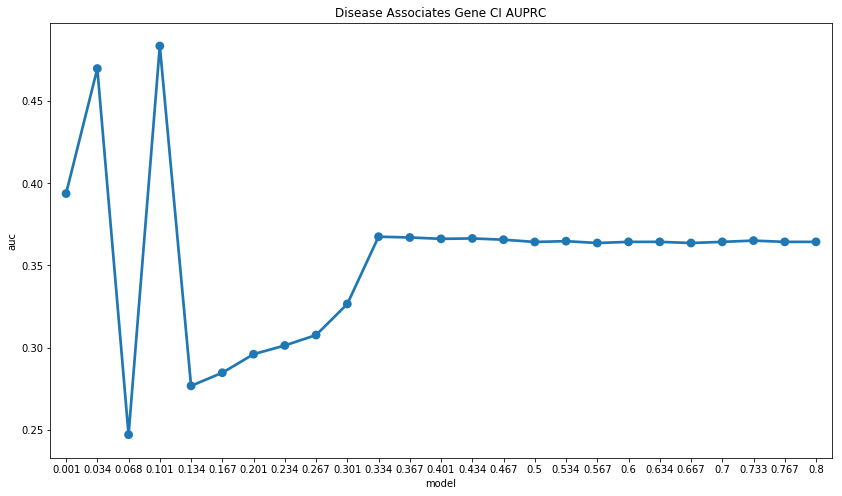

In [21]:
plot_pr_curve(
    ci_marginal_df.drop("candidate_id", axis=1), 
    candidate_dfs['dev'].curated_dsh,
    model_type='scatterplot', xlim=[0, 1], figsize=(14,8), 
    plot_title="Disease Associates Gene CI AUPRC"
)

## Does modeling dependencies aid in performance?

In [ ]:
from snorkel.learning.structure import DependencySelector
gen_da_models = {
    "{}".format(parameter):train_generative_model(
        label_matricies['train'],
        burn_in=100,
        epochs=100,
        reg_param=parameter,
        step_size=1/label_matricies['train'].shape[0],
        deps=DependencySelector().select(label_matricies['train']),
        lf_propensity=True
    )
    for parameter in tqdm_notebook(regularization_grid)
}

In [13]:
da_marginal_df = pd.DataFrame(pd.np.array([
    gen_da_models[model_name].marginals(label_matricies['dev'])
    for model_name in sorted(gen_da_models.keys())
]).T, columns=sorted(gen_da_models.keys()))
da_marginal_df['candidate_id'] = candidate_dfs['dev'].candidate_id.values
da_marginal_df.head(2)

,0.001,0.034,0.068,0.101,0.134,0.167,0.201,0.234,0.267,0.301,...,0.534,0.567,0.6,0.634,0.667,0.7,0.733,0.767,0.8,candidate_id
0,1.0,0.999748,0.999049,0.998147,0.997181,0.996066,0.994615,0.992850,0.990036,0.983760,...,0.925683,0.926234,0.928037,0.929446,0.931568,0.933372,0.935066,0.936782,0.938132,22586
1,1.0,0.999975,0.999895,0.999803,0.999726,0.999663,0.999604,0.999551,0.999491,0.999372,...,0.998526,0.998610,0.998713,0.998794,0.998878,0.998951,0.999019,0.999082,0.999137,22686


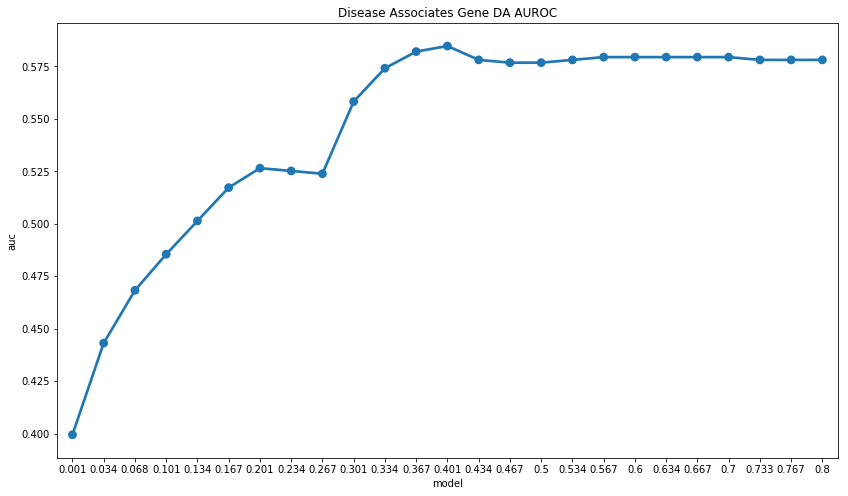

In [26]:
da_aucs = plot_roc_curve(
    da_marginal_df.drop("candidate_id", axis=1), 
    candidate_dfs['dev'].curated_dsh,
    model_type='scatterplot', xlim=[0,1], figsize=(14,8),
    plot_title="Disease Associates Gene DA AUROC"
)

In [24]:
da_auc_stats_df = get_auc_significant_stats(candidate_dfs['dev'], da_aucs).sort_values('auroc', ascending=False)
da_auc_stats_df

mu: 378.000000, sigma: 61.991935


,auroc,u,z_u,p_value
0.401,0.584656,442.0,1.032392,0.150944
0.367,0.582011,440.0,1.000130,0.158624
0.7,0.579365,438.0,0.967868,0.166555
0.667,0.579365,438.0,0.967868,0.166555
0.634,0.579365,438.0,0.967868,0.166555
0.6,0.579365,438.0,0.967868,0.166555
0.567,0.579365,438.0,0.967868,0.166555
0.767,0.578042,437.0,0.951737,0.170615
0.733,0.578042,437.0,0.951737,0.170615
0.534,0.578042,437.0,0.951737,0.170615


From this data frame, the best performing model had the following parameters: 100-burnin, 100-epochs, 0.2-regularization. By looking at the top nine models, the regularization parameter stays at 0.2. The pattern of regularization is the same with the conditionally independent model. This means using 0.2 is a good choice for regularization. The amount of burnin and epochs can vary.

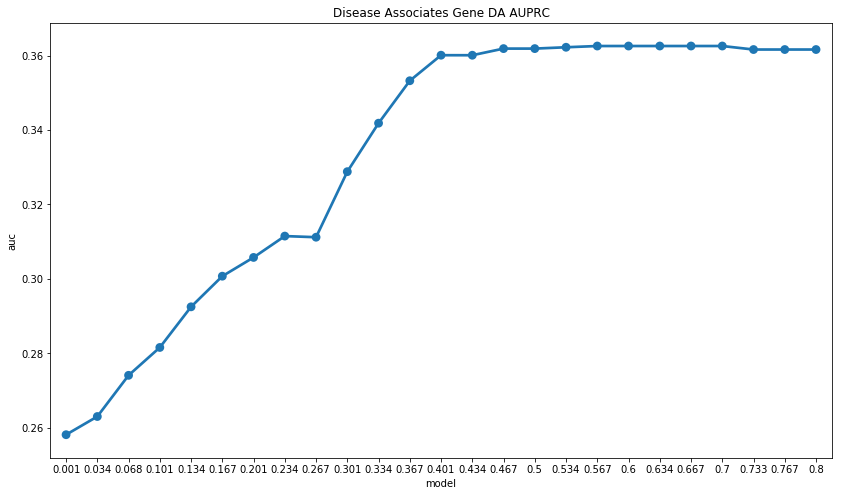

In [31]:
plot_pr_curve(
    da_marginal_df.drop("candidate_id", axis=1), 
    candidate_dfs['dev'].curated_dsh,
    model_type='scatterplot', xlim=[0, 1], figsize=(14,8),
    plot_title="Disease Associates Gene DA AUPRC"
)

In [28]:
best_model_ci = '0.334'
best_model_da = '0.401'
test_marginals_df = pd.DataFrame(pd.np.array([
    gen_ci_models[best_model_ci].marginals(label_matricies['test']),
    gen_da_models[best_model_da].marginals(label_matricies['test'])
]).T, columns=['CI', 'DA'])
test_marginals_df['candidate_id'] = candidate_dfs['test'].candidate_id.values
test_marginals_df.head(2)

,CI,DA,candidate_id
0,0.961763,0.984119,228511
1,0.716979,0.846896,235489


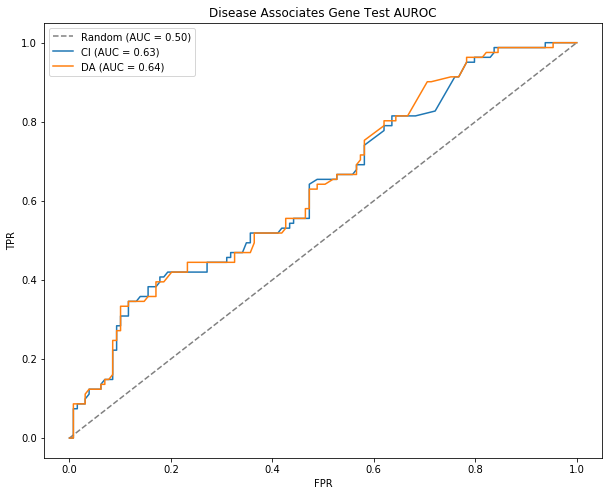

In [30]:
_ = plot_roc_curve(
    test_marginals_df.drop('candidate_id',axis=1), 
    candidate_dfs['test'].curated_dsh,
    model_type='curve', xlim=[0,0.7], figsize=(10,8), 
    plot_title="Disease Associates Gene Test AUROC"
)

Printed above are the best performing models from the conditinally independent model and the dependency aware model. These reults support the hypothesis that modeling depenency structure improves performance compared to the conditionally indepent assumption. Now that the best parameters are found the next step is to begin training the discriminator model to make the actual classification of sentneces.